### Importacao de Libs Necessárias

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
import datetime
import numpy as np
from xgboost import XGBRegressor
import sklearn.model_selection as ms
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
import shap




### Funções Auxiliares para trabalhar com Data Frame Específico


In [0]:

def create_perc_field(df,field_name):
    for delay in ['_d5','_d4','_d3','_d2','_d1','']:
        df['var_perc_'+field_name+delay]= round( (df[field_name+delay].astype(float)-df[field_name+'_d6'].astype(float))/ df[field_name+delay].astype(float) ,6)
 
    return df

def drop_columns(df,col_pref):
    to_drop = [idx for idx in df.columns if idx.startswith(col_pref)]
    df = df.drop(columns = to_drop)

    return df

### Adicionando Infos ao Set Inicial e Criando Set que será utilizado em Modelos Individuais de Fundos


In [0]:
base_full = pd.read_csv('base_final_fundos.csv',sep=";",decimal=",")
base_full = base_full.sort_values(['cod_cnpj','date'],ascending = [True,True])

indices = ['selic','bovespa','dolar','dow_30','ipca_15','tx_cambio']
var_perc_indices_d0 = ['var_perc_' +s for s in indices]

#### Criando Colunas de Variacoes Percentuais dos indices
for field in indices:
    base_full = create_perc_field(base_full,field)

#### Criando colunas de Variacoes Percentuais das cotas

base_full = create_perc_field(base_full,'vl_cota')
    
#### Dropando Valor dos Indices em D+0 (Percentual e Normal)
base_analise = base_full.drop(columns = indices)
base_analise = base_analise.drop(columns = var_perc_indices_d0 )


#### Dropando Valor das cotas da analise - Trabalhando Apenas com variações percentuais

base_analise = drop_columns(base_analise,'vl_cota')

##### Dropando Outras colunas adicionais 

base_analise = base_analise.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1','prim_key'])





### Descrição da análise realizada:

##### Utilizaremos o XGBoost para realizar regressões tentando prever a variação percentual do valor cota de fundos de investimento externo em relação ao valor de 6 dias. Serão Realizadas 3 análises:

##### - Regressão utilizando os valores das variações percentuais dos  dias anteriores ( sempre com base no valor da cota há seis dias atrás)
##### - Regressão anterior, excluindo os valores das variações percentuais dos dias anteriores (puramente com base no uso de indicadores)
##### - Rgressão anterior, excluindo os valores brutos dos índices de mercado 


##### Em cada análise iremos dividir a base em 6 folds . Os 5 primeiros serão utilizados em um cross validation, para verificar se não há uma variação muito abrupta do erro médio quadrático. Uma vez validado, o sexto fold será utilizado para métrica de acurácia final do modelo.

##### Além do XGBoost, será utilizad a função RandomizedSearchCV. Ela realiza a estimativa dos melhores parâmetros do XGBoost  dentro uma lista de parâmetros específicos passados, com base num score pré definido. Neste Caso utilizaremos o erro médio quadrático

In [0]:
##### Parametros do XGboost utilizados na análise:

xgb  = XGBRegressor()
params = {'nthread':[4], 
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [100]}
clf = RandomizedSearchCV(xgb, param_distributions=params, n_iter=1, scoring='neg_mean_squared_error', n_jobs=10)

### Análise para Fundos de Investimento Externo - Análise com Indicadores

##### Filtrando Base, Ordenando por Data e Fazendo a separação de folds 

In [0]:
##### Filtrando Base e Excluindo Colunas que não serão utilizadas
base_analise_model =  base_analise[base_analise['Fundo de Investimento no Exterior']==1]
base_analise_model = drop_columns(base_analise_model,'Fundo de')
base_analise_model= base_analise_model.sort_values(['cod_cnpj','date'],ascending = [True,True]).reset_index(drop=True)

base_analise_model= base_analise_model.drop(columns = ['cod_cnpj','date'])

X = base_analise_model.drop(columns=['var_perc_vl_cota'])
X = X.apply(pd.to_numeric)
Y = base_analise_model.pop('var_perc_vl_cota')
Y = Y.apply(pd.to_numeric)

##### Separando a base de validação da base geral

nfolds = 6
cv = ms.KFold(n_splits=nfolds,shuffle= False)
current_fold = 0
indexes = {}
for index_test,index_train in cv.split(X):
    indexes.update({str(current_fold): index_train})
    current_fold+=1
    
##### Separando ultimo fold para validação     

X_validation = X.iloc[indexes['5']]
X_model = X[~X.index.isin(indexes['5'])]

Y_validation = Y.iloc[indexes['5']]
Y_model = Y[~X.index.isin(indexes['5'])]




##### Realizando Cross Validation do Modelo 

In [0]:
nfolds = 5
cv = ms.KFold(n_splits=nfolds,shuffle= False)
estimators = []
mses = []
train_indexes = {}
current_fold = 0


for train_index, test_index in cv.split(X_model):
    print(current_fold)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    print("training...")
    clf.fit(X_train, y_train)
    estimators.append(clf.best_estimator_)
    print("Predict...")
    y_pred = clf.predict(X_test)
    mses.append(mean_squared_error(y_test, y_pred))
    current_fold+=1

0
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
1
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
2
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
3
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
4
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...


##### Resultados do Cross Validation

In [0]:
print('mse: ', mses )
print('valor médio: ',np.mean(mses))
print('desvio padrão: ',np.std(mses))

mse:  [2.4771068836837208e-05, 4.323327909268339e-05, 0.0005935019873309962, 0.0005845622350325435, 0.0006318380715554548]
valor médio:  0.00037558132836970306
desvio padrão:  0.00027941117208575333


##### Uma vez que tivemos um resultado satisfatório para o cross validation, sem muita variação entre os folds vamos utilizar todos para rodar um modelo final e verificar o seu erro médio quadrático.

##### Em comparação com os fundos de ações e multimercado, o valor da predição é um pouco pior. 

In [0]:
X_train, X_test = X_model, X_validation
y_train, y_test = Y_model, Y_validation
clf.fit(X_train, y_train)
final_model = clf.best_estimator_
y_pred = clf.predict(X_test)
print('Erro Médio Quadrático Final: ', mean_squared_error(y_test, y_pred))

C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Erro Médio Quadrático Final:  2.7549785668431037e-05


##### Vamos verificar agora como as variáveis explicam ao modelo. Inicialmente utilizaremos o features_importance do XGBoost

In [0]:
fts_importance = pd.DataFrame(data = np.transpose(np.array([X_validation.columns , final_model.feature_importances_])),
                              columns = ['feature','importance'])
fts_importance = fts_importance.sort_values(by =  'importance' , ascending = False)
fts_importance.head(10)

,feature,importance
77,var_perc_vl_cota_d1,0.264949
76,var_perc_vl_cota_d2,0.0879261
75,var_perc_vl_cota_d3,0.0265263
32,tx_cambio_d3,0.0208584
28,ipca_15_d5,0.0168889
62,var_perc_dow_30_d1,0.0166467
47,var_perc_selic_d1,0.0165679
65,var_perc_ipca_15_d3,0.0161254
22,dow_30_d5,0.0148404
63,var_perc_ipca_15_d5,0.0143745


#### Agora vamos utilizar o shap para visualizar a importancia dos valores das features no modelo

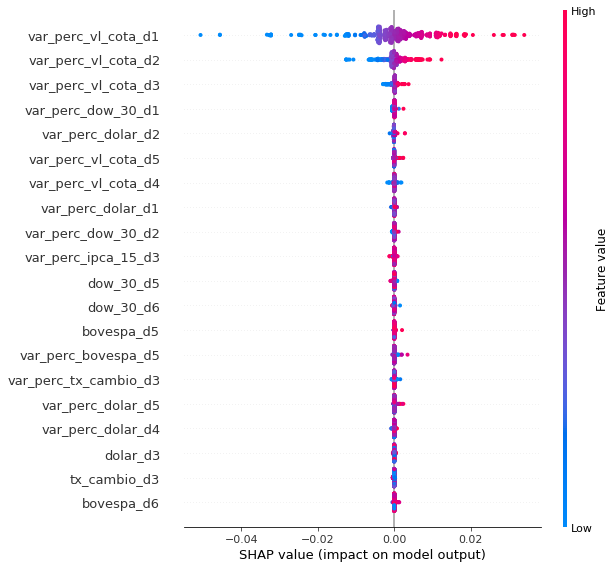

In [0]:
test = X_validation.sample(frac=1)[1:500]
explainer = shap.TreeExplainer(final_model,feature_dependence='independent')
shap_values = explainer.shap_values(test,approximate=True,tree_limit = 50)
shap.summary_plot(shap_values, test)


##### Assim como no caso dos fundos de ação, o valor das cotas acaba sendo um preditor muito superior do que o valor do índices propriamente dito. Vamos excluir a mesma do modelo e rodá-lo novamente, com as mesmas premissas:

In [0]:
X_validation,X_model = drop_columns(X_validation,'var_perc_vl_cota'), drop_columns(X_model,'var_perc_vl_cota')

nfolds = 5
cv = ms.KFold(n_splits=nfolds,shuffle= False)
estimators = []
mses = []
train_indexes = {}
current_fold = 0


for train_index, test_index in cv.split(X_model):
    print(current_fold)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    print("training...")
    clf.fit(X_train, y_train)
    estimators.append(clf.best_estimator_)
    print("Predict...")
    y_pred = clf.predict(X_test)
    mses.append(mean_squared_error(y_test, y_pred))
    current_fold+=1

print('mse: ', mses )
print('valor médio: ',np.mean(mses))
print('desvio padrão: ',np.std(mses))    

0
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
1
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
2
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
3
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
4
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
mse:  [0.0005956573388132427, 3.130291050065057e-05, 0.0005926710370288117, 9.960737183978369e-06, 4.675333644578541e-05]
valor médio:  0.0002552690719944937
desvio padrão:  0.00027695490275136996


##### Assim como nos outrso casos, temos um preditor razoável , mesmo eliminando os valores das cotas propriamente dito. Vamos agora avaliar o mse final do modelo e a importância das features

In [0]:
X_train, X_test = X_model, X_validation
y_train, y_test = Y_model, Y_validation
clf.fit(X_train, y_train)
final_model = clf.best_estimator_
y_pred = clf.predict(X_test)
print('Erro Médio Quadrático Final: ', mean_squared_error(y_test, y_pred))

C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Erro Médio Quadrático Final:  0.00018417122401994407


In [0]:
fts_importance = pd.DataFrame(data = np.transpose(np.array([X_model.columns , final_model.feature_importances_])),
                              columns = ['feature','importance'])
fts_importance = fts_importance.sort_values(by =  'importance' , ascending = False)
fts_importance.head(10)

,feature,importance
62,var_perc_dow_30_d1,0.0545298
57,var_perc_dolar_d1,0.0347771
61,var_perc_dow_30_d2,0.0343655
34,tx_cambio_d5,0.03032
33,tx_cambio_d4,0.0253701
37,netEquity,0.0253437
60,var_perc_dow_30_d3,0.0224707
39,investmentConditions.administrationRate,0.0219317
26,ipca_15_d3,0.0210356
56,var_perc_dolar_d2,0.0202584


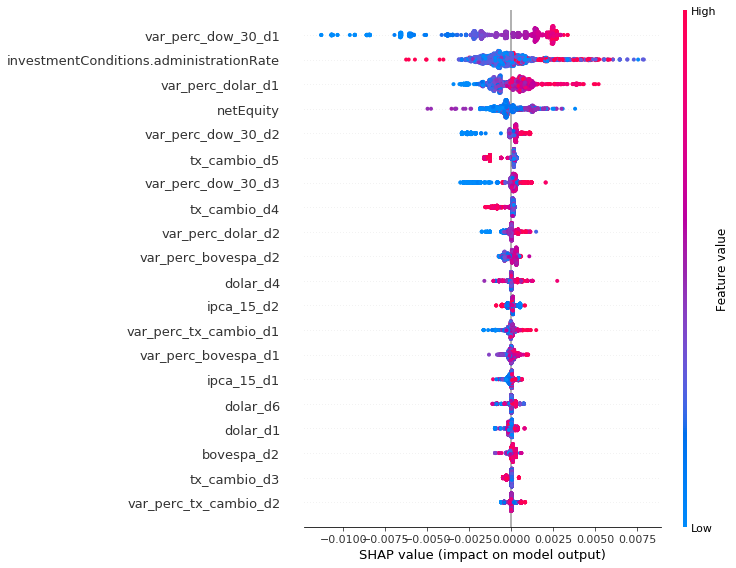

In [0]:
test = X_validation.sample(frac=1)[1:2000]
explainer = shap.TreeExplainer(final_model,feature_dependence='independent')
shap_values = explainer.shap_values(test,approximate=True,tree_limit = 50)
shap.summary_plot(shap_values, test)

##### Assim como esperado, temos que o valor do dolar e do indíce  dow jones são as features que mais explicam o modelo, visto que esses fundos investem em ativos internacionais. 

##### Além disso, a taxa de administração se mostrou com uma influência ainda mais alta que no caso de fundos multimercado. Abaixo plotamos uma relação do mesmo com o dolar:

##### Fundos com taxas de adminstração mais altas passam a ter aumentos mais significativos em períodos em que o dolar está em alta e quedas superiores quando a mesma está em queda. Para fundos cm taxa de admistração mais baixa, o comportamento se inverte

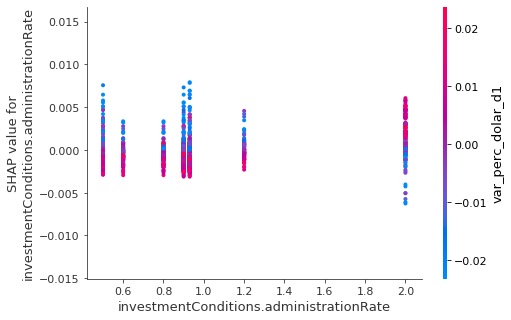

In [0]:
shap.dependence_plot('investmentConditions.administrationRate', shap_values, test)

#### Vamos tentar excluir o valor bruto dos índices e realizar as análises novamente:

In [0]:
for indice in indices:
    X_validation,X_model = drop_columns(X_validation,indice), drop_columns(X_model,indice)

nfolds = 5
cv = ms.KFold(n_splits=nfolds,shuffle= False)
estimators = []
mses = []
train_indexes = {}
current_fold = 0


for train_index, test_index in cv.split(X_model):
    print(current_fold)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    print("training...")
    clf.fit(X_train, y_train)
    estimators.append(clf.best_estimator_)
    print("Predict...")
    y_pred = clf.predict(X_test)
    mses.append(mean_squared_error(y_test, y_pred))
    current_fold+=1

print('mse: ', mses )
print('valor médio: ',np.mean(mses))
print('desvio padrão: ',np.std(mses))        

0
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
1
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
2
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
3
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
4
training...


C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predict...
mse:  [2.3801170241767858e-05, 3.323962905875355e-05, 2.7463277644463868e-05, 1.918733606472093e-05, 4.675333644578541e-05]
valor médio:  3.0088949891098322e-05
desvio padrão:  9.517395338497564e-06


##### É nitida a melhora do poder predivito do modelo excluindo o valor bruto das variáveis. Vamos agora avaliar a MSE Final:

In [0]:
X_train, X_test = X_model, X_validation
y_train, y_test = Y_model, Y_validation
clf.fit(X_train, y_train)
final_model = clf.best_estimator_
y_pred = clf.predict(X_test)
print('Erro Médio Quadrático Final: ', mean_squared_error(y_test, y_pred))

C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\U000960\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Erro Médio Quadrático Final:  0.0001824704161070408


In [0]:
fts_importance = pd.DataFrame(data = np.transpose(np.array([X_model.columns , final_model.feature_importances_])),
                              columns = ['feature','importance'])
fts_importance = fts_importance.sort_values(by =  'importance' , ascending = False)
fts_importance.head(10)

,feature,importance
26,var_perc_dow_30_d1,0.0905346
25,var_perc_dow_30_d2,0.0686995
21,var_perc_dolar_d1,0.0601399
3,investmentConditions.administrationRate,0.055415
1,netEquity,0.0508754
36,var_perc_tx_cambio_d1,0.0449471
24,var_perc_dow_30_d3,0.0447717
20,var_perc_dolar_d2,0.0395816
29,var_perc_ipca_15_d3,0.0370929
11,var_perc_selic_d1,0.0358636


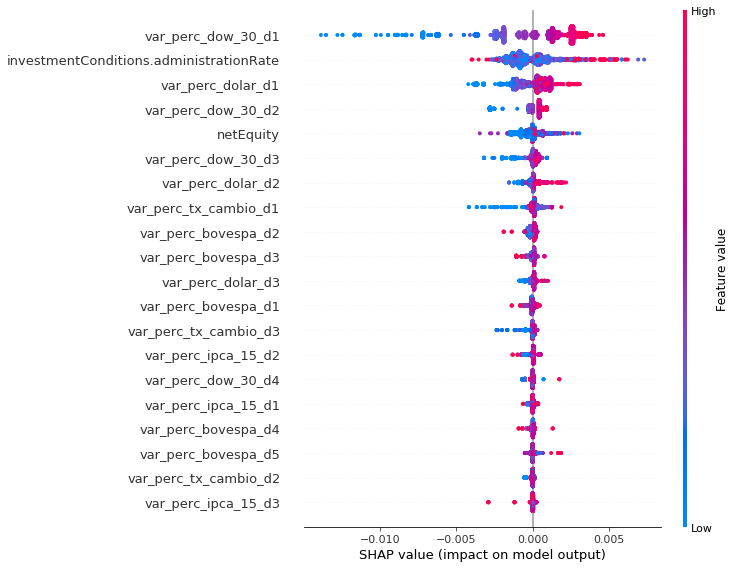

In [0]:
test = X_validation.sample(frac=1)[1:2000]
explainer = shap.TreeExplainer(final_model,feature_dependence='independent')
shap_values = explainer.shap_values(test,approximate=True,tree_limit = 50)
shap.summary_plot(shap_values, test)

##### Podemos observar uma melhora na capacidade preditiva no modelo sem uma mudança brusca na utilização de features do mesmo. Trabalhando apenas com variações percentuais dos indíces e features dos fundos é possível uma predição mais acurada da variação da cota.